<a href="https://colab.research.google.com/github/Shreejan-git/pytorch-complete-course/blob/main/pytorch_nn_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

2.0.1+cu118


In [3]:
!nvidia-smi

Sun Sep 10 05:15:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Dummy data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

# split data
split_size = int(0.8 * len(X))
X_train = X[:split_size]
y_train = y[:split_size]

X_test = X[split_size:]
y_test = y[split_size:]

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([50, 1]) torch.Size([50, 1])
torch.Size([40, 1]) torch.Size([40, 1])
torch.Size([10, 1]) torch.Size([10, 1])


In [5]:
X_train.device # remember our data is in cpu

device(type='cpu')

In [7]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Notes while creating a custom model:**


1.   If we are creating our custom neural network module, it must inherit from nn.Module. https://pytorch.org/docs/stable/generated/torch.nn.Module.html
2.   Always call the __ init __ (constructor) of the parent class using the super().__ init__ (). This is a mandatory step. If we do not call the parents's constructor, we will have problems while training and saving the model. (linked with point 3)
3. When we are inheriting from nn.Module, it is mandatory to add forward method. Later while training the model, setting our to model to traning model with model.train(X_train), it will automatically forward_pass using forward method.
4. Below, nn.parameter's work is to mark that variable as a learnable parameter. nn.parameter will track it while training.


Below's model architecture is a scratch implementation of a linear model to demonstrate how weight and a bias is initialized and used in a forward method. We have nn.Linear() to do all of these is a single line of code.

In [8]:
class SimpleLinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(1,
                               requires_grad=True,
                               dtype=torch.float32))
    self.bias = nn.Parameter(torch.rand(1,
                             requires_grad=True,
                             dtype=torch.float32))

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.weight * X + self.bias
# Set the manual seed
# torch.manual_seed(42)
model = SimpleLinearRegression() # Initializing the model
model

SimpleLinearRegression()

In [9]:
print(next(model.parameters()).device) # checking whether our model is running on a CPU or GPU.
# Since it is running on a CPU, let's change it to a GPU
model.to(device)
print(next(model.parameters()).device)

cpu
cuda:0


In [10]:
model.state_dict()

OrderedDict([('weight', tensor([0.3248], device='cuda:0')),
             ('bias', tensor([0.4651], device='cuda:0'))])

In [19]:
class SimpleLinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=1,
                                out_features=1)

    def forward(self, X_train: torch.Tensor) -> torch.Tensor:
        return self.linear(X_train)

model_v2 = SimpleLinearRegressionV2()

print(model_v2)
print(model_v2.state_dict())

SimpleLinearRegressionV2(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
OrderedDict([('linear.weight', tensor([[-0.1290]])), ('linear.bias', tensor([0.1635]))])


In [20]:
print(next(model_v2.parameters()).device) # model's paramaters are in CPU
model_v2.to(device)
print(next(model_v2.parameters()).device)

cpu
cuda:0


**Resources for loss and optimization functions**

Pytorch Loss function: https://pytorch.org/docs/stable/nn.html#loss-functions , https://neptune.ai/blog/pytorch-loss-functions

Pytorch optimization functions: https://pytorch.org/docs/stable/optim.html

In [11]:
# Defining the loss function.
loss_fun = nn.L1Loss() # L1Loss is MAE loss function.
print(loss_fun)

L1Loss()


We can define any optimization function. like Adam, SGD, Adagrad.

1st parameter of SGD is the model's parameters. We can get this by writing model.parameters().

2nd parameter is learning rate (lr). Higher the value, the bigger the steps will be while reducing the gradient to global minima and vice versa.

In [21]:
# Defining the optimization function.
optimizer = torch.optim.SGD(params=model_v2.parameters(), lr = 0.01)

In [13]:
epochs = 200

**Setting the training and evaluation loop**

**Below code explanation:**


1.   Line 3: model.train() This line sets the PyTorch model (model) to training mode. In training mode, the model keeps track of the operations and layers that require gradients for backpropagation. This is necessary because some layers, like dropout or batch normalization(if we have one) must be turned on while training and turned off while evaluating.
2.   Line 6: y_pred = model(X_train) This line performs a forward pass through the model using the training data X_train. It computes the predicted values (y_pred) based on the current model parameters. This step is a fundamental part of training, as it computes the model's predictions.
3. line 12 [IMPORTANT] In PyTorch, when you perform a backward pass (loss.backward()), the gradients of the model's parameters are accumulated in the respective parameter tensors. But, when you're training a neural network with a single loss function and a single backward pass per iteration, you typically want to reset the gradients to zero before each backward pass to avoid accumulating gradients from previous iterations. Without zeroing out gradients, if you run multiple training iterations, the gradients will accumulate over time. This can lead to incorrect gradient updates, making your model's training unstable or divergent. By using optimizer.zero_grad() before each backward pass, you ensure that the gradients are cleared, and only the gradients of the current iteration are used to update the model parameters.
4. line 16: loss.backward() This line computes the gradients of the loss with respect to the model's parameters using backpropagation. It calculates how much each parameter needs to be adjusted to minimize the loss. This is a critical step in training neural networks.
5. line 19: optimizer.step() After computing the gradients, you update the model's parameters using an optimization algorithm. The optimizer is responsible for adjusting the model's weights based on the computed gradients.
6. line26: model.eval() When the evaluation mode is set, few things that happens while training will be haulted like dropout layers might not drop out units during evaluation, and batch normalization uses the population statistics instead of batch statistics.
7. line27. torch.inference_mode() is a context manager to disable funcanility such as gradient tracking during the inference/testing time.

After that we forward pass with the validation data set and calculate the loss accordingly.



In [24]:
track_epochs = []
track_training_loss = []
track_validation_loss = []

# device agnostic code for data
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # Set the model to a traning mode
    model_v2.train()

    # Forward pass
    y_pred = model_v2(X_train)

    # Calculate the loss
    loss = loss_fun(y_pred, y_train)

    # set the gradients to zero
    optimizer.zero_grad()

    # Perform backpropagation on the loss with respect to the parameters of the model.
    # Parameters are those which we set requires_grad = True.
    loss.backward()

    # step the updated value to the corresponding parameters.
    optimizer.step()

    # set the model to the evaluation mode.
    model_v2.eval()
    with torch.inference_mode(): #context manager
        val_pred = model_v2(X_test) # validation set
        val_loss = loss_fun(val_pred, y_test)

    if epoch % 10 == 0:
        track_epochs.append(epoch)
        track_training_loss.append(loss)
        track_validation_loss.append(val_loss)
        print(f"Epoch: {epoch} | Train loss: {loss} | Validation loss: {val_loss}")

Epoch: 0 | Train loss: 0.07426566630601883 | Validation loss: 0.1727420836687088
Epoch: 10 | Train loss: 0.07082879543304443 | Validation loss: 0.16515640914440155
Epoch: 20 | Train loss: 0.06740035861730576 | Validation loss: 0.1568838655948639
Epoch: 30 | Train loss: 0.06396203488111496 | Validation loss: 0.14861133694648743
Epoch: 40 | Train loss: 0.06052687391638756 | Validation loss: 0.14102567732334137
Epoch: 50 | Train loss: 0.05709722265601158 | Validation loss: 0.13275311887264252
Epoch: 60 | Train loss: 0.05365842208266258 | Validation loss: 0.12448058277368546
Epoch: 70 | Train loss: 0.05022493749856949 | Validation loss: 0.1168949231505394
Epoch: 80 | Train loss: 0.046793606132268906 | Validation loss: 0.10862238705158234
Epoch: 90 | Train loss: 0.04335479065775871 | Validation loss: 0.10034983605146408
Epoch: 100 | Train loss: 0.039923012256622314 | Validation loss: 0.09276418387889862
Epoch: 110 | Train loss: 0.03648998960852623 | Validation loss: 0.08449163287878036
Epoc

In [25]:
model_v2.state_dict()

OrderedDict([('linear.weight', tensor([[0.6722]], device='cuda:0')),
             ('linear.bias', tensor([0.3115], device='cuda:0'))])

In [43]:
# Saving and loading the model
import os
if not os.path.exists('saved_models'):
    !mkdir "saved_models"

FILE_NAME = 'linear_model_v2.pth'
BASE_DIR = 'saved_models'
DIR_PATH = os.path.join(BASE_DIR, FILE_NAME)
print(DIR_PATH)

saved_models/linear_model_v2.pth


In [45]:
torch.save(model_v2.state_dict(), DIR_PATH)

In [49]:
# loading the saved dict
loaded_model_v2 = SimpleLinearRegressionV2()
loaded_model_v2.load_state_dict(torch.load(DIR_PATH))
# model.state_dict()

<All keys matched successfully>

In [52]:
loaded_model_v2.to(device)

SimpleLinearRegressionV2(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

AttributeError: ignored

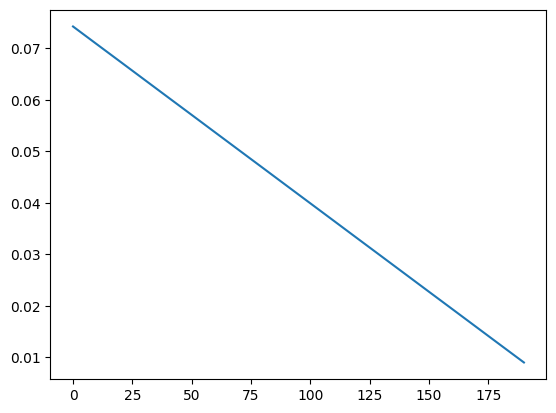

In [27]:
# Plot the learning curve
plt.plot(track_epochs, np.array(torch.tensor(track_training_loss).numpy()), label="Training loss")
plt.plot(track_epochs, track_validation_loss, label="Validation loss")
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()